In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from playlist_recommender.modelling import model_pipeline, utils
import joblib
import json
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from collections import Counter
from pathlib import Path
from scipy import stats

2022-10-14 15:54:52.066861: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Function definitions

In [3]:
def get_top_n_prediction_indices(prediction_array: np.array, n: int):
    return np.flip(np.argsort(prediction_array)[-n:])

In [4]:
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

In [5]:
def get_top_n_prediction_probas(prediction_array: np.array, n: int):
    return sorted(prediction_array, reverse=True)[:n]

In [6]:
def make_prediction(model, row, le_dict: dict):
    return le_dict[str(np.argmax(model.predict(row)))]

In [7]:
def get_top_n_predictions(prediction_array: np.array, n: int, encoder_dict: dict):
    top_indices = get_top_n_prediction_indices(prediction_array, n)
    predictions_list = []
    for idx in top_indices:
        predictions_list.append(encoder_dict[str(idx)])
    return predictions_list

# Predicting


In [8]:
X, y = utils.prep_playlist_df()
X_train, X_test, y_train, y_test = model_pipeline.make_best_transformation_pipeline(
    X, y
)

pipeline dumped


In [9]:
trained_model_dir = Path(Path.cwd(), "trained_nn_model")
model = tf.keras.models.load_model(trained_model_dir)

2022-10-14 15:55:07.598337: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
liked_songs_dir = Path(Path.cwd().parent, "data", "liked_songs_df.pkl")
liked_songs = pd.read_pickle(liked_songs_dir)

In [11]:
liked_artists = liked_songs["artist_names"].to_list()
liked_tracks = liked_songs["track_names"].to_list()
zipped_artists_tracks = tuple(zip(liked_artists, liked_tracks))

In [12]:
pipeline = joblib.load("pipeline.pkl")

In [13]:
json_dir = Path(Path.cwd(), "label_encoding.json")
with open(json_dir, "r") as f:
    le_dict = json.load(f)

In [14]:
transformed = pipeline.transform(liked_songs)

In [15]:
predictions = model.predict(transformed)

21/21 [==============================] - 1s 9ms/step


In [16]:
top_1_predicted_labels = []
for array in predictions:
    _predictions_labels = get_top_n_predictions(array, 1, le_dict)
    top_1_predicted_labels.append(_predictions_labels)
top_1_predictions_dict = dict(zip(zipped_artists_tracks, top_1_predicted_labels))

In [17]:
top_1_predictions_values = list(
    itertools.chain.from_iterable(list(top_1_predictions_dict.values()))
)

In [18]:
predictions_dict = {"first":[], 
                    "first_proba":[], 
                    "second":[], 
                    "second_proba":[], 
                    "third":[], 
                    "third_proba":[]}

for i, array in enumerate(predictions):
    predictions_dict["first"].append(le_dict[str(get_top_n_prediction_indices(array, 1)[0])])
    predictions_dict["first_proba"].append(get_top_n_prediction_probas(array, n=1)[0])
    predictions_dict["second"].append(le_dict[str(get_top_n_prediction_indices(array, 2)[1])])
    predictions_dict["second_proba"].append(get_top_n_prediction_probas(array, n=2)[1])
    predictions_dict["third"].append(le_dict[str(get_top_n_prediction_indices(array, 3)[2])])
    predictions_dict["third_proba"].append(get_top_n_prediction_probas(array, n=3)[2])

In [19]:
df = pd.DataFrame.from_dict(predictions_dict)
df["artist name"] = liked_artists
df["track name"] = liked_tracks

In [20]:
df.head()

,first,first_proba,second,second_proba,third,third_proba,artist name,track name
0,80's Hits,0.490375,Guilty Pleasures,0.110621,Summer Songs,0.110617,Elton John,All The Girls Love Alice - Remastered 2014
1,Discovered Weekly,0.336936,Your Top Songs 2019,0.252830,Easy Sunday,0.168270,Brian Protheroe,Pinball
2,Austin 2.0,0.286915,Summer Tunes,0.132632,Discovered Weekly,0.129641,Lo Moon,Dream Never Dies
3,Summer Songs,0.702904,80's Hits,0.135461,Chill,0.045541,Nation of Language,Across That Fine Line
4,Summer Songs,0.123992,Old Summer Stuff,0.121701,Discovered Weekly,0.088711,Harvey Danger,Flagpole Sitta


In [21]:
df.sort_values("first_proba", ascending=False).head()

,first,first_proba,second,second_proba,third,third_proba,artist name,track name
471,Gym,0.999530,00s house party,0.000150,Explosive Choruses,0.000089,Shinedown,Cut the Cord
378,Chill,0.996888,Koala Kontrol,0.000772,Your Top Songs 2019,0.000509,xxyyxx,Dmt
494,Gym,0.996333,Guilty Pleasures,0.001442,00s house party,0.000816,Kanye West,Famous
423,Chill,0.995842,Day of the Dead,0.001195,Summer Tunes,0.001011,DOPE LEMON,Neon Lights
343,Gym,0.995748,Guilty Pleasures,0.001754,00s house party,0.001089,Royal Blood,I Only Lie When I Love You


# Filtering

The most confident matches are all songs that already exist in the playlist they are being matched to. 
Although this is a reasurring result, it isn't very helpful for identifying new playlist tracks. 
Therefore if a song already exists in a playlist, it shouldn't be included.

In [22]:
playlist_df_dir = Path(Path.cwd().parent, "data", "playlist_df.pkl")
playlist_df = pd.read_pickle(playlist_df_dir)

In [23]:
# Have to rename the playlist_df columns to match the predictions df for merging
playlist_df_filtered = playlist_df[["track_names", "artist_names", "playlist_name"]]
playlist_df_filtered = playlist_df_filtered.rename(
    columns={
        "track_names": "track name",
        "artist_names": "artist name",
        "playlist_name": "first prediction",
    }
)

In [24]:
""" merge the playlist_df with the predictions_df
extract tracks that exist in both liked songs and predictions
combine the predictions_df with the tracks that exist in both
then drop duplicates, leaving only the prediction tracks that dont 
exist in the liked song df
"""

playlist_df_merged = playlist_df_filtered.merge(df, how="left", indicator=True)
exist_in_both = playlist_df_merged[playlist_df_merged["_merge"] == "both"]
final_prediction_df = (
    pd.concat([df, exist_in_both])
    .drop_duplicates(keep=False, subset=["artist name", "track name"])
    .drop(["_merge","first prediction"], axis=1)
    .reset_index(drop=True)
)

In [25]:
final_prediction_df.sort_values(by="first_proba", ascending=False).head()

,first,first_proba,second,second_proba,third,third_proba,artist name,track name
328,Gym,0.996333,Guilty Pleasures,0.001442,00s house party,0.000816,Kanye West,Famous
156,Summer Tunes,0.992955,Austin,0.002048,Chill,0.001384,Sam Feldt,Start Again
300,Gym,0.992930,Summer Tunes,0.002107,Guilty Pleasures,0.001538,Jax Jones,You Don't Know Me
298,Gym,0.992784,briz party songz,0.002090,00s house party,0.001624,Kanye West,Waves
34,Floyd,0.992685,60s/70s,0.003045,Classic Rock,0.002366,Pink Floyd,Lost for Words


In [26]:
final_prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438 entries, 0 to 437
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   first         438 non-null    object 
 1   first_proba   438 non-null    float32
 2   second        438 non-null    object 
 3   second_proba  438 non-null    float32
 4   third         438 non-null    object 
 5   third_proba   438 non-null    float32
 6   artist name   438 non-null    object 
 7   track name    438 non-null    object 
dtypes: float32(3), object(5)
memory usage: 22.4+ KB


In [27]:
print(f"{len(df) - len(final_prediction_df)} songs removed from prediction df")

231 songs removed from prediction df


# Prediction Visualization

In [28]:
SPOTIFY_GREEN = "#1DB954"

In [29]:
filtered_counts = Counter(final_prediction_df["first"])
filtered_plot_data = sorted(
    final_prediction_df["first"], key=filtered_counts.get, reverse=True
)
counts_df = pd.DataFrame.from_dict(filtered_counts, orient="index").reset_index()
counts_df.columns = ["playlist name", "count"]

Lets see what the breakdown of predictions by playlist looks like.

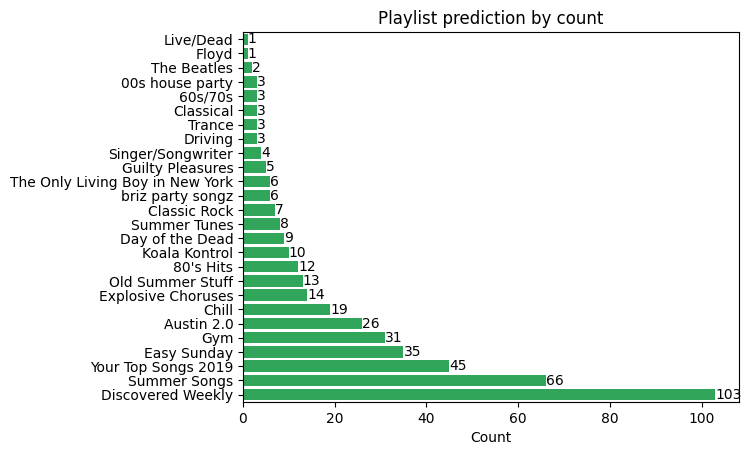

In [30]:
ax = sns.barplot(x='count', 
                 y='playlist name', 
                 data=counts_df.sort_values(by='count'), 
                 color =SPOTIFY_GREEN)
ax.bar_label(ax.containers[0]);
ax.set_title("Playlist prediction by count")
ax.set_ylabel("")
ax.set_xlabel("Count");

This generally aligns with my expectations. I was using the "Discovered Weekly" playlist as a similar catchall for songs I liked before switching to "Liked songs" so it's unsuprising a lot of Liked songs fit into this. 

Next I'll investigate the breakdown of confidence for the first playlist prediction. 

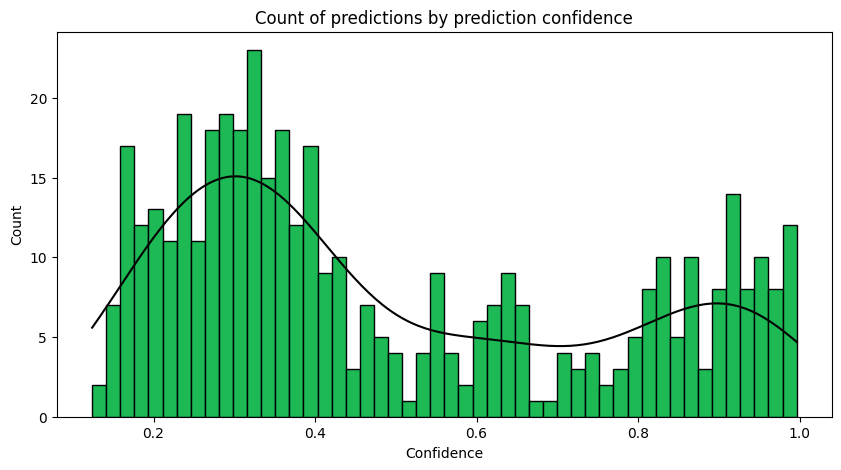

In [31]:
fig, ax = plt.subplots(figsize = (10,5))
ax = sns.histplot(data = final_prediction_df, 
             x = 'first_proba', 
             kde = True, 
             bins = 50, 
             color = SPOTIFY_GREEN, 
             alpha = 1)
ax.lines[0].set_color('black') #passing kde color to kdekwargs doesnt seem to work
ax.set_xlabel('Confidence');
ax.set_title("Count of predictions by prediction confidence");

Most tracks are only categorised into a playlist with <50% confidence. Obviously the higher the confidence the better, and if I were to look deploy this to suggest playlist matching for users, I would implement a threshold (perhaps 75%) in order to minimise poor suggestions. Some songs just dont fit into any particular playlist, and its better to not force it. 

In [40]:
def count_over_threshold(thresh:float=0.75):
    return len(final_prediction_df[final_prediction_df['first_proba'] > thresh])

In [42]:
threshold = 0.75
print(f"{count_over_threshold(threshold)} of {len(final_prediction_df)} songs were found with a confidence probability of over {threshold}")

106 of 438 songs were found with a confidence probability of over 0.75


Next lets see what the top songs for each playlist are. 

In [32]:
top_predictions_by_playlist_indices = final_prediction_df.groupby('first')['first_proba'].nlargest(1).index.get_level_values(1)

(final_prediction_df.iloc[top_predictions_by_playlist_indices]
 .sort_values(by = 'first_proba', ascending = False)
 .drop(['second', 'second_proba', 'third', 'third_proba'], axis = 1))

,first,first_proba,artist name,track name
328,Gym,0.996333,Kanye West,Famous
156,Summer Tunes,0.992955,Sam Feldt,Start Again
34,Floyd,0.992685,Pink Floyd,Lost for Words
35,Classic Rock,0.981210,Bob Dylan,Ballad of a Thin Man
258,Singer/Songwriter,0.971670,Of Monsters and Men,Love Love Love
88,Easy Sunday,0.971600,Michael Kiwanuka,Piano Joint (This Kind Of Love)
262,The Beatles,0.969079,The Beatles,Mother Nature's Son - Remastered
391,Koala Kontrol,0.968377,XYLØ,America
22,Chill,0.962222,Tame Impala,The Boat I Row
152,Explosive Choruses,0.960559,Blur,Country House


I would agree with most of these selections. The biggest exception is "The Tallest Man on Earth - Love is All" being binned into the "Day of the Dead" playlist, where all tracks are Grateful Dead covers. However it's not unsurprising the algorithm failed to pick up on this niche requirement. 

The net successfully picked up on all artist-specific playlists - 
* Floyd
* The Beatles
* The Only Boy Living in New York
* Live/Dead

The algorithm also categorised a soundtrack track into the "Classical" playlist. Allthough techincally not classical, I can see that the track would share a lot of features seen in classical music. 

I'm interested in knowing if the algorithm is just putting tracks into more populated tracks. To investigate this I'll see how the ratio of playlist length to playlist prediction count in.

In [33]:
predict_vs_track_count_df = (final_prediction_df['first']
 .value_counts()
 .to_frame()
 .merge(playlist_df['playlist_name']
        .value_counts()
        .to_frame(), 
        left_index=True, 
        right_index=True)
 .reset_index())
predict_vs_track_count_df = predict_vs_track_count_df.rename(columns={"index":"playlist name","first":"prediction", "playlist_name":"playlist"})
predict_vs_track_count_df["percent"] = predict_vs_track_count_df['prediction'] / predict_vs_track_count_df['playlist'] * 100
predict_vs_track_count_df.sort_values(by = 'percent', ascending = False)

,playlist name,prediction,playlist,percent
3,Easy Sunday,35,40,87.500000
5,Austin 2.0,26,33,78.787879
7,Explosive Choruses,14,21,66.666667
2,Your Top Songs 2019,45,73,61.643836
15,briz party songz,6,11,54.545455
1,Summer Songs,66,129,51.162791
8,Old Summer Stuff,13,35,37.142857
14,The Only Living Boy in New York,6,18,33.333333
0,Discovered Weekly,103,336,30.654762
6,Chill,19,97,19.587629


In [34]:

markers = ["o", "v", "^", "1", "s", "*"]
colours = ['tab:blue','tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']

plot_df = predict_vs_track_count_df.copy()
plot_df['marker'] = np.resize(markers, plot_df.shape[0])
plot_df['colour'] = np.resize(colours, plot_df.shape[0])

Text(0.5, 1.0, 'Count of playlist tracks vs predictions')

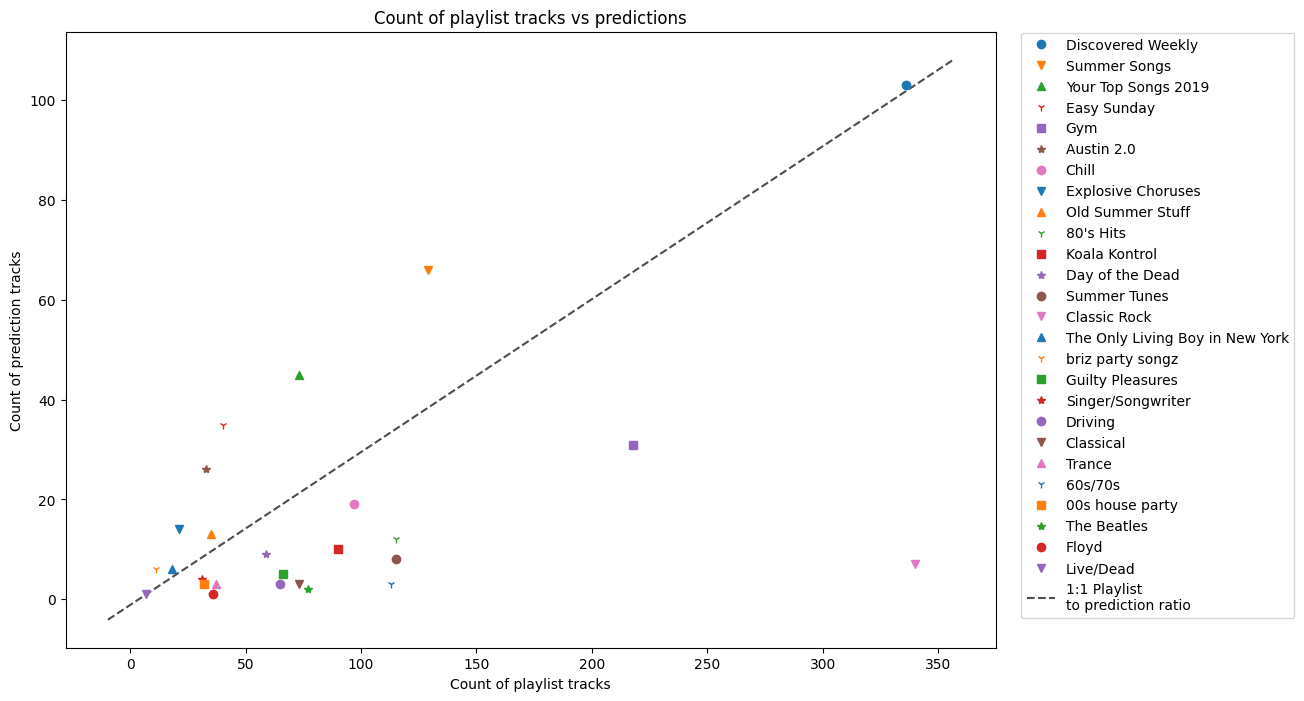

In [35]:
fig, ax = plt.subplots(figsize = (12,8))
for row in plot_df.itertuples(index = False, name = 'Pandas'):
    ax.plot(row.playlist, row.prediction, marker = row.marker, color = row.colour, label = row._0, linestyle = "None")
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3", zorder = 1, label = "1:1 Playlist\nto prediction ratio")
plt.legend(bbox_to_anchor=(1.02, 1.01))
ax.set_xlabel("Count of playlist tracks")
ax.set_ylabel("Count of prediction tracks")
ax.set_title("Count of playlist tracks vs predictions")

Looks like generally the more tracks a playlist contains the more likely it is to have a song categorised into it (the effect of this can actaully be seen in the next graphs regression plot).
Although setting class weights into the neural net should have reduced the impact of the imbalanced training set, it hasnt fixed it completely. It could also be the case that playlists with lots of tracks include a wider range of song genres/styles and therefore more songs do genuinely fit into them. 

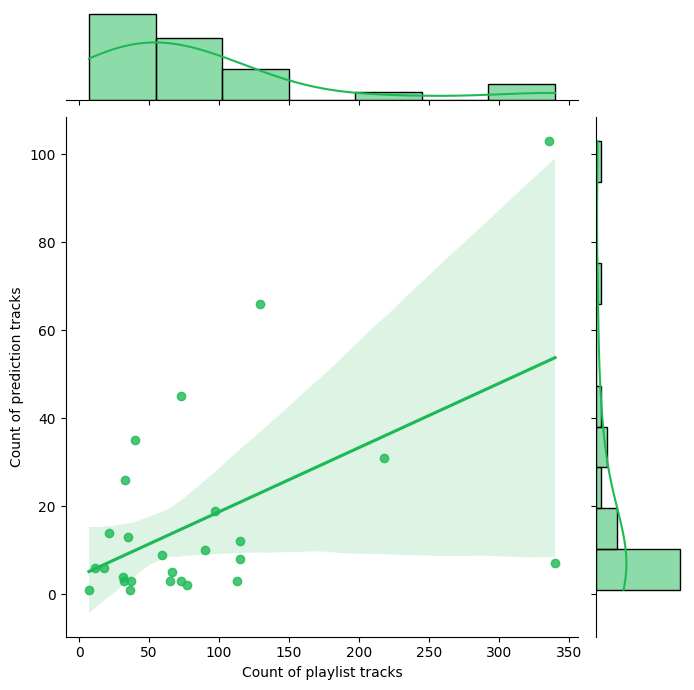

In [36]:
j= sns.jointplot(data = plot_df,x = 'playlist', y='prediction', kind="reg",  color = SPOTIFY_GREEN, height = 7)
j.set_axis_labels('Count of playlist tracks', 'Count of prediction tracks')

# Confusion Matrix

Although created in the modelling section, no analysis was done on the confusion matrix. Here, I will just open the already created image rather than rerunning the code. 

![confusion matrix](confusion_matrix.png)

Although the confusion matrix doesn't look great on first viewing, the most common mix ups are entirely understandable and are usually where several playlists could realistically contain the same or very similar songs. 

For example "Classic Rock" and "Driving" both contain similar songs from the same eras and rock-heavy rhythms. 

"Easy Sunday" is often mixed up with "Singer Songwriter" and "The Only Boy Living in New York". This again makes sense because most of Easy Sunday songs are acousting singer/soongwriter style. 

Finally "Discovered Weekly" is often miscategorised, however this is because for a long time I was saving tracks that I liked from Spotify's "Discover Weekly" into here. Therefore the playlist has a very wide range of songs, leading to a non-coherent grouping. Even a human would struggle to decide whether ot not to place a liked song into here. 